In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (basal area, QMD, TPA, etc.)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys, time
import pandas as pd
import rioxarray as rxr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif')
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
# Grab some raster metadata
shp, gt, wkt, nd = treemap_da.shape, treemap_da.spatial_ref.GeoTransform, treemap_da.rio.crs, treemap_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {treemap_da[0].dtype}")
gc.collect() # clean up

Shape: (97383, 154221); 
GeoTransform: -2362845.0 30.0 0.0 3180555.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float64


54

In [3]:
# load and prepare our study region for cropping TreeMap
# Southern Rockies ecoregion bounds (buffered)
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_srme.gpkg')
srm = gpd.read_file(fp)
# Crop the raster by the SRM bounds
bounds = srm.total_bounds # total bounds of ecoregion
treemap_da_c = treemap_da.rio.clip_box(
    minx=bounds[0]+10000, # +10km buffer
    miny=bounds[1]+10000, 
    maxx=bounds[2]+10000, 
    maxy=bounds[3]+10000
)
print(f"Cropped TreeMap to SRM bounds w/ 10km buffer.")
del treemap_da, bounds
gc.collect() # clean up

Cropped TreeMap to SRM bounds w/ 10km buffer.


54

In [4]:
# load the aggregated FRP grid
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry'],
      dtype='object')

In [29]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_tmid = compute_band_stats(grid, treemap_da_c, 'grid_index', attr='tm_id')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 0.55 minutes.

~~~~~~~~~~



In [30]:
# tidy columns
grid_tmid['count'] = grid_tmid['count'].astype(int)
grid_tmid['total_pixels'] = grid_tmid['total_pixels'].astype(int)
grid_tmid.rename(columns={'total_pixels': 'forest_pixels'}, inplace=True)
grid_tmid.head(10)

,grid_index,tm_id,count,forest_pixels,pct_cover
0,1955419,12665,3,169,1.775148
1,1955419,20313,5,169,2.958580
2,1955419,45478,8,169,4.733728
3,1955419,46099,1,169,0.591716
4,1955419,51905,5,169,2.958580
5,1955419,53570,3,169,1.775148
6,1955419,53601,1,169,0.591716
7,1955419,53611,4,169,2.366864
8,1955419,53614,1,169,0.591716
9,1955419,53638,2,169,1.183432


In [62]:
# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# join to the grid data
grid_trees = grid_tmid.merge(tree_tbl, on='tm_id', how='left')

del tree_tbl

grid_trees.head()

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')


,grid_index,tm_id,count,forest_pixels,pct_cover,CN,STATUSCD,TPA_UNADJ,SPCD,COMMON_NAME,SCIENTIFIC_NAME,SPECIES_SYMBOL,DIA,HT,ACTUALHT,CR,SUBP,TREE,AGENTCD
0,1955419,12665,3,169,1.775148,11746831010690,1,6.018046,202,Douglas-fir,Pseudotsuga menziesii,PSME,6.5,31.0,31.0,83.0,2,1,NaN
1,1955419,12665,3,169,1.775148,11746831010690,1,6.018046,122,ponderosa pine,Pinus ponderosa,PIPO,14.4,46.0,46.0,25.0,1,1,NaN
2,1955419,12665,3,169,1.775148,11746831010690,1,6.018046,202,Douglas-fir,Pseudotsuga menziesii,PSME,5.4,14.0,14.0,65.0,1,2,NaN
3,1955419,12665,3,169,1.775148,11746831010690,1,74.965280,202,Douglas-fir,Pseudotsuga menziesii,PSME,4.0,15.0,15.0,70.0,1,3,NaN
4,1955419,12665,3,169,1.775148,11746831010690,1,6.018046,202,Douglas-fir,Pseudotsuga menziesii,PSME,7.9,33.0,33.0,78.0,2,2,NaN


In [64]:
print(len(grid_trees['tm_id'].unique()))


7235
7235


In [46]:
# Calculate the live basal area for the tree table
# force species name to lower case
grid_trees['COMMON_NAME'] = grid_trees['COMMON_NAME'].str.lower()
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)

# subset to live trees
grid_trees['BA'] = np.pi * (grid_trees['DIA'] / 2) ** 2  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['TREE'] * grid_trees['TPA_UNADJ'] # adjust based on tree counts

# calculate live basal area
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_index', 'COMMON_NAME'], as_index=False)
    .agg(
        balive=('BA_TPAsc', 'sum'),    # Live basal area
        abundance_live=('TREE', 'sum')  # Total live tree count
    )
)

# calculate dead basal area
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_index', 'COMMON_NAME'], as_index=False)
    .agg(
        badead=('BA_TPAsc', 'sum'),    # Live basal area
        abundance_dead=('TREE', 'sum')  # Total live tree count
    )
)

# combine live/dead balive
ba_by_sp = live_metrics.merge(
    dead_metrics, 
    on=['grid_index', 'COMMON_NAME'], 
    how='outer'
).fillna(0).rename(
    columns={'COMMON_NAME': 'SpeciesName'}
)[['grid_index','SpeciesName','balive','badead','abundance_live','abundance_dead']]
ba_by_sp.head(10)

,grid_index,SpeciesName,balive,badead,abundance_live,abundance_dead
0,183297,common or two-needle pinyon,12891.835193,9580.694467,46.0,23.0
1,183297,oneseed juniper,8463.760536,0.000000,4.0,0.0
2,183297,utah juniper,38195.809393,13851.285280,91.0,16.0
3,183298,common or two-needle pinyon,1357.799545,3861.034192,7.0,15.0
4,183298,oneseed juniper,8463.760536,0.000000,4.0,0.0
5,183298,utah juniper,58102.259351,8255.082811,89.0,10.0
6,183299,common or two-needle pinyon,24320.922213,3861.034192,54.0,15.0
7,183299,fremont cottonwood,10858.178195,0.000000,29.0,5.0
8,183299,honey mesquite,142.978509,0.000000,1.0,0.0
9,183299,oneseed juniper,36246.304529,0.000000,34.0,0.0




Species making up 97% of the total *metric*: 

                    SpeciesName        balive    abundance  balive_f  \
89               ponderosa pine  3.525772e+11  622879839.0  0.361834   
65               lodgepole pine  1.949537e+11  583792417.0  0.200072   
51                    grand fir  1.014150e+11  198821651.0  0.104078   
41                  douglas-fir  7.745923e+10  137596550.0  0.079493   
129                   white fir  3.992368e+10   87049749.0  0.040972   
61                 jeffrey pine  3.797264e+10   62857131.0  0.038970   
107               subalpine fir  3.700200e+10  111080808.0  0.037974   
48             engelmann spruce  2.985327e+10   63072999.0  0.030637   
123             western juniper  2.074190e+10   35694670.0  0.021286   
90                quaking aspen  1.814737e+10   54911122.0  0.018624   
124               western larch  1.357073e+10   28428615.0  0.013927   
59                incense-cedar  1.130227e+10   19333412.0  0.011599   
39   curlleaf m

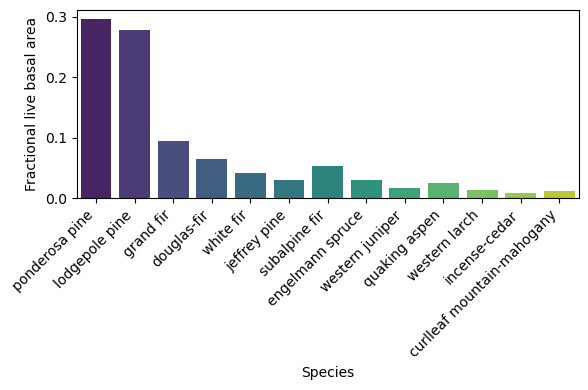

In [59]:
# calculate the landscape fraction (prevalence)
spp_pr = (
    ba_by_sp.groupby('SpeciesName', as_index=False)
    .agg(
        balive=('balive','sum'),
        abundance=('abundance_live', 'sum')
    )
)
# calculate the fraction
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['abundance_f'] = spp_pr['abundance'] / spp_pr['abundance'].sum()

# sort values and plot
spp_pr = spp_pr.sort_values(by='balive_f', ascending=False)

# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['abundance_f_csum'] = spp_pr['abundance_f'].cumsum()
top_species = spp_pr[spp_pr['abundance_f_csum'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total *metric*: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesName', y='abundance_f', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional live basal area')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

    grid_index                  COMMON_NAME  frequency
2       183297                 utah juniper         40
5       183298                 utah juniper         28
11      183299                 utah juniper         28
15      185547                 utah juniper         51
16      185548  common or two-needle pinyon         50


Species making up 97% of the total: 

         COMMON_NAME  frequency  fraction  c_fraction
17    lodgepole pine   13101039  0.506658    0.506658
20    ponderosa pine    5876075  0.227246    0.733904
21     quaking aspen    4305408  0.166503    0.900407
25     subalpine fir    1149194  0.044443    0.944850
11  engelmann spruce     626385  0.024224    0.969074




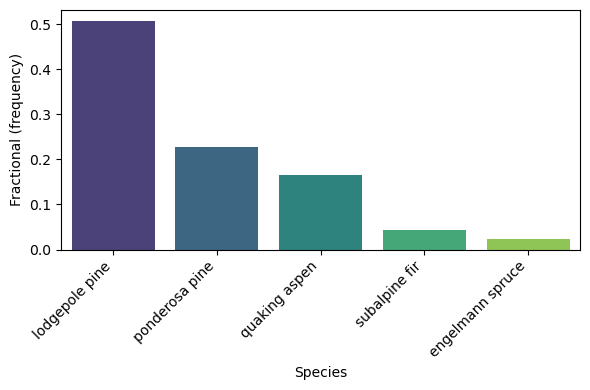

In [61]:
spp_dom = (
    grid_trees.groupby(['grid_index', 'COMMON_NAME'])
    .size()
    .reset_index(name='frequency')  # Count occurrences of each species
    .sort_values(['grid_index', 'frequency'], ascending=[True, False])
    .drop_duplicates('grid_index')  # Keep only the top species per grid_index
)
print(spp_dom.head())

# calculate the landscape fraction (prevalence)
spp_dom = spp_dom.groupby('COMMON_NAME')['frequency'].sum().reset_index()
spp_dom['fraction'] = spp_dom['frequency'] / spp_dom['frequency'].sum()
spp_dom = spp_dom.sort_values(by='fraction', ascending=False)

# which species make up 97% of observations?
spp_dom['c_fraction'] = spp_dom['fraction'].cumsum()
top_species = spp_dom[spp_dom['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='COMMON_NAME', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional (frequency)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for stacked bar plot
stacked_data = comparison_table.set_index('COMMON_NAME')[
    ['fraction_balive', 'fraction_abundance', 'weighted_frequency']
].T

# Plot the stacked bar chart
stacked_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='viridis'
)

# Customize the plot
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Species Contribution by Different Metrics', fontsize=14)
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
# do some species regrouping and renaming
spp_grouping = {
    'pinyon|juniper': 'pinon-juniper',
    ' fir|spruce': 'spruce-fir',
    'ponderosa pine': 'ponderosa',
    'lodgepole pine': 'lodgepole'
}

spp_remap = {}
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_trees[grid_trees['COMMON_NAME'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['COMMON_NAME'].unique()})

# Apply the remap to create a new grouped species column
grid_trees['SpeciesGroup'] = grid_trees['COMMON_NAME'].map(spp_remap).fillna(grid_trees['COMMON_NAME'])

# Verify the updated species groups
print(grid_trees[['COMMON_NAME', 'SpeciesGroup']].drop_duplicates().head(10))

          COMMON_NAME   SpeciesGroup
0         douglas-fir    douglas-fir
1      ponderosa pine      ponderosa
8      lodgepole pine      lodgepole
17        limber pine    limber pine
21      quaking aspen  quaking aspen
31          grand fir     spruce-fir
44      western larch  western larch
53          white fir     spruce-fir
108  engelmann spruce     spruce-fir
119      corkbark fir     spruce-fir


In [12]:
# merge the live basal area
grid_trees = grid_trees.merge(ba_by_species, on=['grid_index', 'tm_id', 'COMMON_NAME'], how='left')
grid_trees[['grid_index','tm_id','count','COMMON_NAME','balive']].head(10)

,grid_index,tm_id,count,COMMON_NAME,balive
0,1955419,12665,3,douglas-fir,34422.862428
1,1955419,12665,3,ponderosa pine,2123.928024
2,1955419,12665,3,douglas-fir,34422.862428
3,1955419,12665,3,douglas-fir,34422.862428
4,1955419,12665,3,douglas-fir,34422.862428
5,1955419,12665,3,douglas-fir,34422.862428
6,1955419,12665,3,douglas-fir,34422.862428
7,1955419,12665,3,ponderosa pine,2123.928024
8,1955419,12665,3,lodgepole pine,1933.353033
9,1955419,12665,3,douglas-fir,34422.862428


In [13]:
# Collapse the tree data to species
row_counts = (
    grid_trees.groupby(['grid_index', 'tm_id', 'COMMON_NAME'])
    .size()
    .reset_index(name='tree_count')  # Name the count column 'tree_count'
)
# Merge the tree_count back into the original grid_trees DataFrame
grid_trees_sp = grid_trees.merge(row_counts, on=['grid_index', 'tm_id', 'COMMON_NAME'], how='left')
grid_trees_sp = grid_trees_sp.drop_duplicates(subset=['grid_index', 'tm_id', 'COMMON_NAME'])
grid_trees_sp[['grid_index', 'tm_id', 'COMMON_NAME', 'SpeciesGroup', 'tree_count', 'balive']].head(10)

,grid_index,tm_id,COMMON_NAME,SpeciesGroup,tree_count,balive
0,1955419,12665,douglas-fir,douglas-fir,22,34422.862428
1,1955419,12665,ponderosa pine,ponderosa,3,2123.928024
8,1955419,12665,lodgepole pine,lodgepole,2,1933.353033
17,1955419,12665,limber pine,limber pine,1,10345.783103
21,1955419,12665,quaking aspen,quaking aspen,3,11926.900277
31,1955419,20313,grand fir,spruce-fir,14,18172.700420
32,1955419,20313,douglas-fir,douglas-fir,6,22086.606882
44,1955419,20313,western larch,western larch,1,703.501529
52,1955419,45478,douglas-fir,douglas-fir,12,16230.778526
53,1955419,45478,white fir,spruce-fir,19,56528.284987



Species contributing to 97% of the burned area:
     SpeciesGroup  maj_spp_count  fraction  c_fraction
28      lodgepole        2160147  0.255692    0.255692
40      ponderosa        1997617  0.236453    0.492145
48     spruce-fir        1993621  0.235980    0.728125
41  quaking aspen         853791  0.101061    0.829186
38  pinon-juniper         569900  0.067458    0.896644
14    douglas-fir         389517  0.046106    0.942750



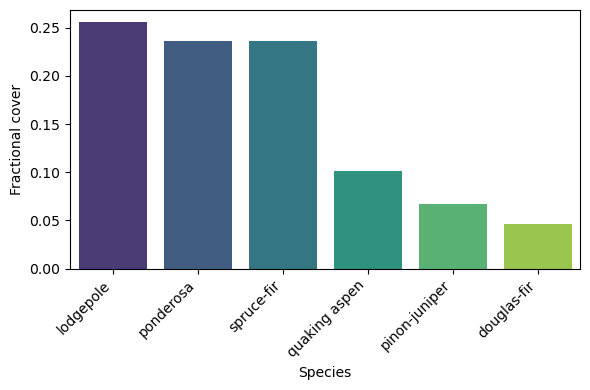

In [16]:
# identify the dominant forest species for each "tm_id"
spp_dominance = (
    grid_trees_sp.groupby(['tm_id', 'SpeciesGroup'])['balive']  # Sum tree counts (or use another metric)
    .sum()
    .reset_index()
    .sort_values(['tm_id', 'balive'], ascending=[True, False])
    .drop_duplicates('tm_id')  # Keep only the top species per tm_id
)

# join back to the tm_id summary
grid_tmid_spp = grid_tmid.merge(spp_dominance[['tm_id', 'SpeciesGroup']], on='tm_id', how='left')

# identify the landscape proportion of dominant species
spp_pr = (
    grid_tmid_spp.groupby('SpeciesGroup')['count']
    .sum()
    .reset_index()
    .rename(columns={'count': 'maj_spp_count'})
    .sort_values(by='maj_spp_count', ascending=False)
)

# calculate the fraction
spp_pr['fraction'] = spp_pr['maj_spp_count'] / spp_pr['maj_spp_count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)

# Identify species contributing 97% of the burned area
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.97]
print(f"\nSpecies contributing to 97% of the burned area:\n{top_species}\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesGroup', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# Calculate the species gradient (proportions) based on Tree Table
grid_trees.columns

Index(['grid_index', 'tm_id', 'count', 'forest_pixels', 'pct_cover', 'CN',
       'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME', 'SCIENTIFIC_NAME',
       'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR', 'SUBP', 'TREE',
       'AGENTCD', 'SpeciesGroup', 'balive'],
      dtype='object')

In [26]:
# Calculate abundance (count) and dominance (basal area) for each species in each tm_id
sp_abundance = (
    grid_trees.groupby(['tm_id', 'COMMON_NAME'])['TREE'] 
    .sum()
    .reset_index()
    .rename(columns={'TREE': 'abundance'})
)
sp_dominance = (
    grid_trees.groupby(['tm_id', 'COMMON_NAME'])['balive']
    .sum()
    .reset_index()
    .rename(columns={'balive': 'dominance'})
)

# join these together
composition = sp_abundance.merge(sp_dominance, on=['tm_id', 'COMMON_NAME'], how='outer').fillna(0)

# Normalize abundance/dominance within each tm_id (plot)
composition['abundance'] = (
    composition.groupby('tm_id')['abundance'].transform(lambda x: x / x.sum())
)
composition['dominance'] = (
    composition.groupby('tm_id')['dominance'].transform(lambda x: x / x.sum())
)

# check the results
composition.head()

,tm_id,COMMON_NAME,abundance,dominance
0,3726,common or two-needle pinyon,0.040670,0.000225
1,3726,gambel oak,0.394737,0.188287
2,3726,ponderosa pine,0.507177,0.808994
3,3726,rocky mountain juniper,0.057416,0.002493
4,3734,common or two-needle pinyon,0.570000,0.000000


In [23]:
ba_by_species[ba_by_species['tm_id'] == 3726]

,grid_index,tm_id,COMMON_NAME,balive
3752,212554,3726,common or two-needle pinyon,1000.919085
3753,212554,3726,gambel oak,64353.795621
3754,212554,3726,ponderosa pine,119817.550172
3755,212554,3726,rocky mountain juniper,11078.407942
3992,214792,3726,common or two-needle pinyon,1000.919085
3993,214792,3726,gambel oak,64353.795621
3994,214792,3726,ponderosa pine,119817.550172
3995,214792,3726,rocky mountain juniper,11078.407942
4527,214804,3726,common or two-needle pinyon,1000.919085
4528,214804,3726,gambel oak,64353.795621


In [27]:
composition[composition['tm_id'] == 3726]

,tm_id,COMMON_NAME,abundance,dominance
0,3726,common or two-needle pinyon,0.040670,0.000225
1,3726,gambel oak,0.394737,0.188287
2,3726,ponderosa pine,0.507177,0.808994
3,3726,rocky mountain juniper,0.057416,0.002493


In [25]:
grid_trees[grid_trees['tm_id'] == 3726]

,grid_index,tm_id,count,forest_pixels,pct_cover,CN,STATUSCD,TPA_UNADJ,SPCD,COMMON_NAME,...,SPECIES_SYMBOL,DIA,HT,ACTUALHT,CR,SUBP,TREE,AGENTCD,SpeciesGroup,balive
46227006,212554,3726,5,196,2.551020,31217656010690,1,6.018046,122,ponderosa pine,...,PIPO,10.5,54.0,54.0,55.0,1,1,NaN,ponderosa,119817.550172
46227007,212554,3726,5,196,2.551020,31217656010690,1,6.018046,122,ponderosa pine,...,PIPO,7.4,49.0,49.0,43.0,1,2,NaN,ponderosa,119817.550172
46227008,212554,3726,5,196,2.551020,31217656010690,1,6.018046,122,ponderosa pine,...,PIPO,17.2,64.0,64.0,73.0,1,3,NaN,ponderosa,119817.550172
46227009,212554,3726,5,196,2.551020,31217656010690,1,6.018046,122,ponderosa pine,...,PIPO,8.1,56.0,56.0,50.0,1,4,NaN,ponderosa,119817.550172
46227010,212554,3726,5,196,2.551020,31217656010690,1,6.018046,122,ponderosa pine,...,PIPO,11.3,60.0,60.0,49.0,1,5,NaN,ponderosa,119817.550172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46233784,214804,3726,2,182,1.098901,31217656010690,1,74.965280,814,gambel oak,...,QUGA,1.8,17.0,17.0,27.0,4,20,NaN,gambel oak,64353.795621
46233785,214804,3726,2,182,1.098901,31217656010690,1,74.965280,814,gambel oak,...,QUGA,2.6,22.0,22.0,30.0,4,21,NaN,gambel oak,64353.795621
46233786,214804,3726,2,182,1.098901,31217656010690,1,74.965280,814,gambel oak,...,QUGA,2.8,21.0,21.0,35.0,4,22,NaN,gambel oak,64353.795621
46233787,214804,3726,2,182,1.098901,31217656010690,1,74.965280,814,gambel oak,...,QUGA,3.6,23.0,23.0,40.0,4,23,NaN,gambel oak,64353.795621


In [ ]:
# test tree table
tree_tbl[tree_tbl['tm_id'] == 21404][['tm_id','COMMON_NAME','DIA','HT','CR','TREE']]